## 서포트 벡터 머신 (SVM) 심층 분석

서포트 벡터 머신(SVM)은 두 데이터 그룹을 분리하는 최적의 '결정 경계(Decision Boundary)'를 찾는 지도학습 분류 모델이다. SVM은 단순히 데이터를 나누는 것을 넘어, 두 그룹 사이의 '마진(Margin)'을 최대로 넓혀 가장 안정적이고 일반화 성능이 높은 분류 기준을 수립하는 것을 목표로 한다.

### 1. 라이브러리 임포트 및 시각화 함수 정의

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs, make_circles

# 결정 경계, 마진, 서포트 벡터를 시각화하는 함수 정의
def plot_svm_boundary(model, X, y, title):
    """SVM 모델의 결정 경계와 서포트 벡터를 시각화하는 함수"""
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # 축 범위 가져오기
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # 결정 경계를 그리기 위한 격자 생성
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # 결정 경계와 마진 그리기
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # 서포트 벡터 강조 표시
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

### 2. 최적의 경계선과 최대 마진 (Hard Margin)

SVM의 가장 기본적인 목표는 마진 최대화이다. 데이터가 완벽하게 선형적으로 분리될 수 있는 경우, SVM은 오류를 전혀 허용하지 않는 **하드 마진(Hard Margin)** 분류기를 찾는다.

- **결정 경계 (Hyperplane):** 두 클래스를 나누는 기준선. $w^T x + b = 0$
- **마진 (Margin):** 결정 경계($w^T x + b = 0$)와 서포트 벡터가 놓인 경계선들($w^T x + b = \pm 1$) 사이의 거리. SVM은 이 마진($\frac{2}{||w||}$)을 최대화한다.
- **서포트 벡터 (Support Vectors):** 마진 경계선 위에 위치하여 결정 경계를 정의하는 가장 중요한 데이터 포인트.

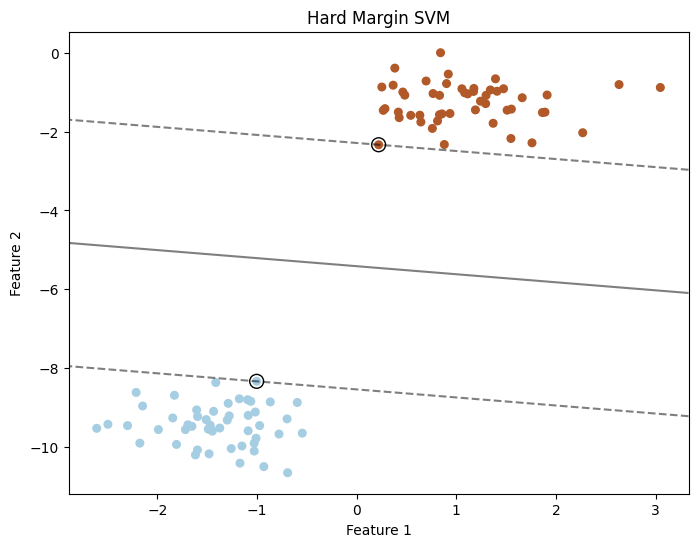

In [2]:
# 완벽하게 분리 가능한 데이터 생성
X_linear, y_linear = make_blobs(n_samples=100, centers=2, random_state=2, cluster_std=0.5)

# 하드 마진에 가까운 SVM 모델 생성 (매우 큰 C 값 사용)
clf_hard = svm.SVC(kernel='linear', C=1e6) # C를 매우 크게 설정하여 오류를 불허
clf_hard.fit(X_linear, y_linear)

# 시각화
plt.figure(figsize=(8, 6))
plot_svm_boundary(clf_hard, X_linear, y_linear, 'Hard Margin SVM')
plt.show()

### 3. 소프트 마진 (Soft Margin)과 비용(C) 파라미터

실제 데이터는 노이즈나 이상치로 인해 완벽하게 분리되지 않는 경우가 많다. 이 때 **소프트 마진(Soft Margin)**은 약간의 분류 오류를 허용하여 더 유연하고 일반화된 결정 경계를 찾는다.

- **비용 (C):** 오류 허용 수준을 조절하는 파라미터. 마진의 폭과 분류 오류 사이의 트레이드오프를 결정한다.
  - **`C`가 크면 (e.g., 100):** 오류에 대한 비용이 커진다. SVM은 오류를 최소화하기 위해 마진을 좁히더라도 데이터를 최대한 정확하게 분류하려고 시도한다. (하드 마진에 가까워짐)
  - **`C`가 작으면 (e.g., 0.1):** 오류에 대한 비용이 작아진다. SVM은 일부 데이터를 잘못 분류하더라도 마진을 최대한 넓히는 방향으로 학습한다. (소프트 마진)

최적화 목표: $$\min_{w, b, \xi} \frac{1}{2} ||w||^2 + C \sum_{i=1}^{n} \xi_i$$
(마진 최대화와 오류($\xi_i$) 최소화 동시 달성)

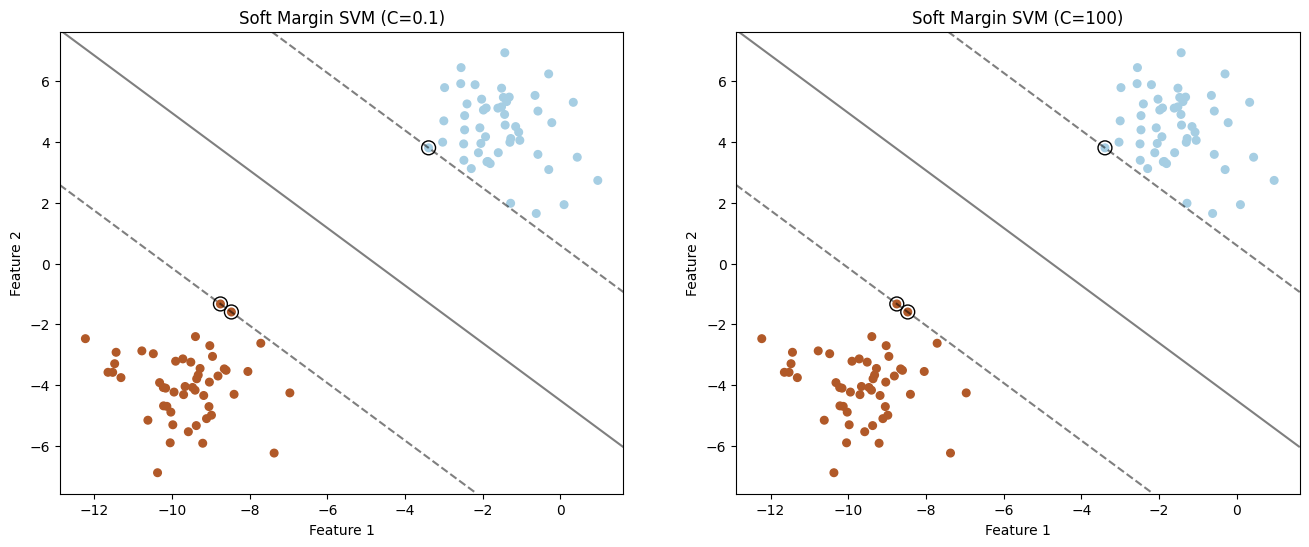

In [3]:
# 약간 겹치는 데이터 생성
X_soft, y_soft = make_blobs(n_samples=100, centers=2, random_state=1, cluster_std=1.2)

# C 값에 따른 모델 비교
C_values = [0.1, 100]
models = [svm.SVC(kernel='linear', C=C).fit(X_soft, y_soft) for C in C_values]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for model, C, ax in zip(models, C_values, axes.ravel()):
    plt.sca(ax)
    plot_svm_boundary(model, X_soft, y_soft, f'Soft Margin SVM (C={C})')

plt.show()

#### 결과 분석
- **C=0.1 (좌측):** 마진이 넓지만, 파란색 점 하나가 마진 안쪽에 포함되며 잘못 분류되는 것을 허용했다. 더 일반적인 모델이다.
- **C=100 (우측):** 모든 데이터를 정확히 분류하기 위해 마진이 매우 좁아졌다. 이상치에 민감할 수 있다.

### 4. 비선형 분리와 커널 트릭 (Kernel Trick)

데이터가 선형적으로 분리 불가능할 때, **커널 트릭**은 데이터를 직접 고차원으로 보내지 않고도, 고차원 공간에서 내적을 계산한 것과 같은 효과를 내어 비선형 결정 경계를 찾게 해주는 기법이다.

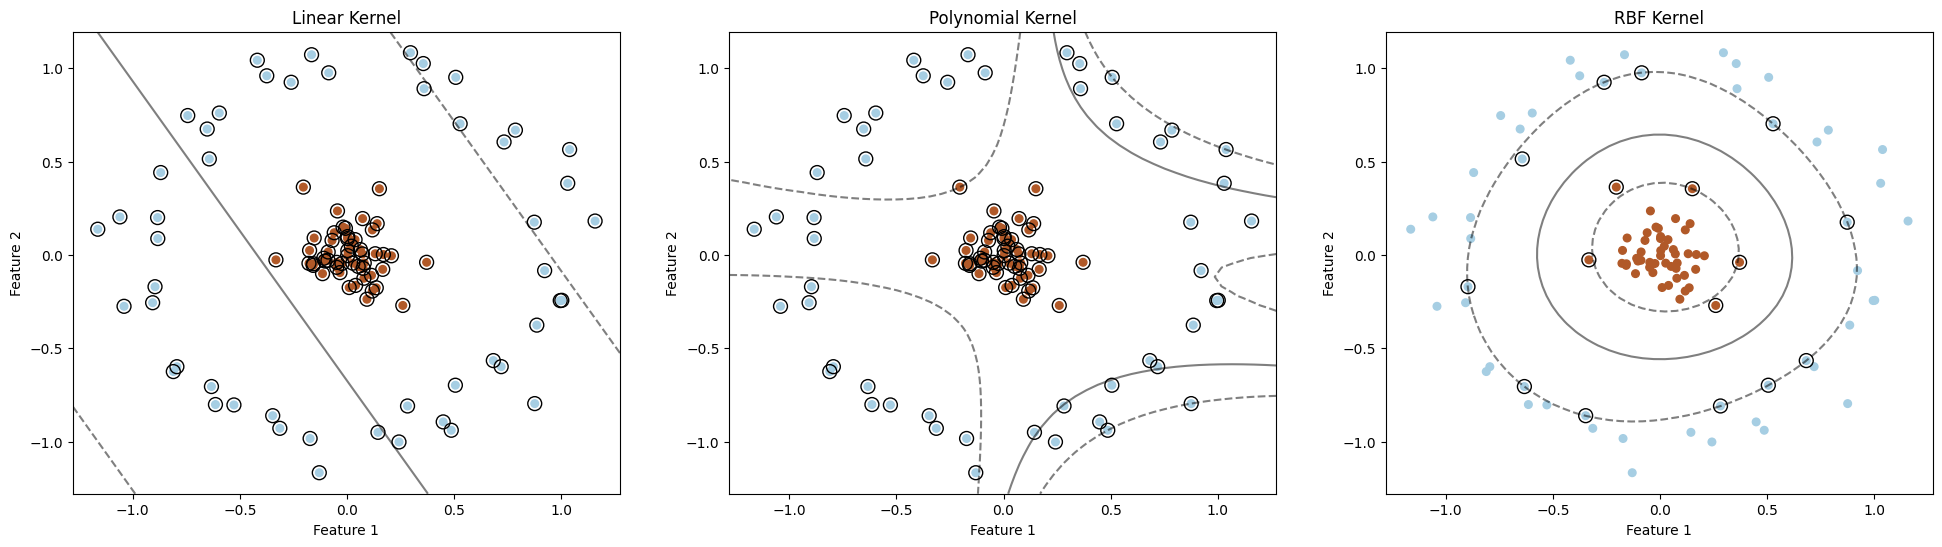

In [4]:
# 비선형 데이터(원형) 생성
X_nonlin, y_nonlin = make_circles(n_samples=100, factor=0.1, noise=0.1, random_state=42)

# 여러 커널로 모델 학습
clf_nl_linear = svm.SVC(kernel='linear').fit(X_nonlin, y_nonlin)
clf_nl_poly = svm.SVC(kernel='poly', degree=3, C=10).fit(X_nonlin, y_nonlin)
clf_nl_rbf = svm.SVC(kernel='rbf').fit(X_nonlin, y_nonlin)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# 선형 커널 시각화
plt.sca(axes[0])
plot_svm_boundary(clf_nl_linear, X_nonlin, y_nonlin, 'Linear Kernel')

# 다항식 커널 시각화
plt.sca(axes[1])
plot_svm_boundary(clf_nl_poly, X_nonlin, y_nonlin, 'Polynomial Kernel')

# RBF 커널 시각화
plt.sca(axes[2])
plot_svm_boundary(clf_nl_rbf, X_nonlin, y_nonlin, 'RBF Kernel')

#### 주요 커널 함수와 결과 분석
- **선형 (Linear) 커널:** $K(x_i, x_j) = x_i^T x_j$
  - 결과: 선형 경계만 생성 가능하므로 원형 데이터를 전혀 분리하지 못함.

- **다항식 (Polynomial) 커널:** $K(x_i, x_j) = (\gamma x_i^T x_j + r)^d$
  - 결과: 데이터의 상호작용을 고려한 곡선 경계를 생성하여 어느 정도 분리함.

- **가우시안 RBF (Gaussian RBF) 커널:** $K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$
  - 결과: 각 점과의 거리를 기반으로 국소적인 특성을 반영하여, 복잡한 비선형 경계를 매우 효과적으로 생성함. 이 경우 가장 이상적인 분리를 보여줌.

### 한 문장 요약

SVM은 데이터 클래스 간의 마진을 최대화하는 결정 경계를 찾고, 소프트 마진과 커널 트릭을 통해 복잡하고 노이즈가 있는 현실 데이터까지 효과적으로 분류하는 강력하고 유연한 알고리즘이다.